In [1]:
import numpy as np
from scipy.stats import poisson
from scipy.optimize import curve_fit
import utils as ut
import matplotlib.pyplot as plt
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True


config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

## Una Señal DAQ

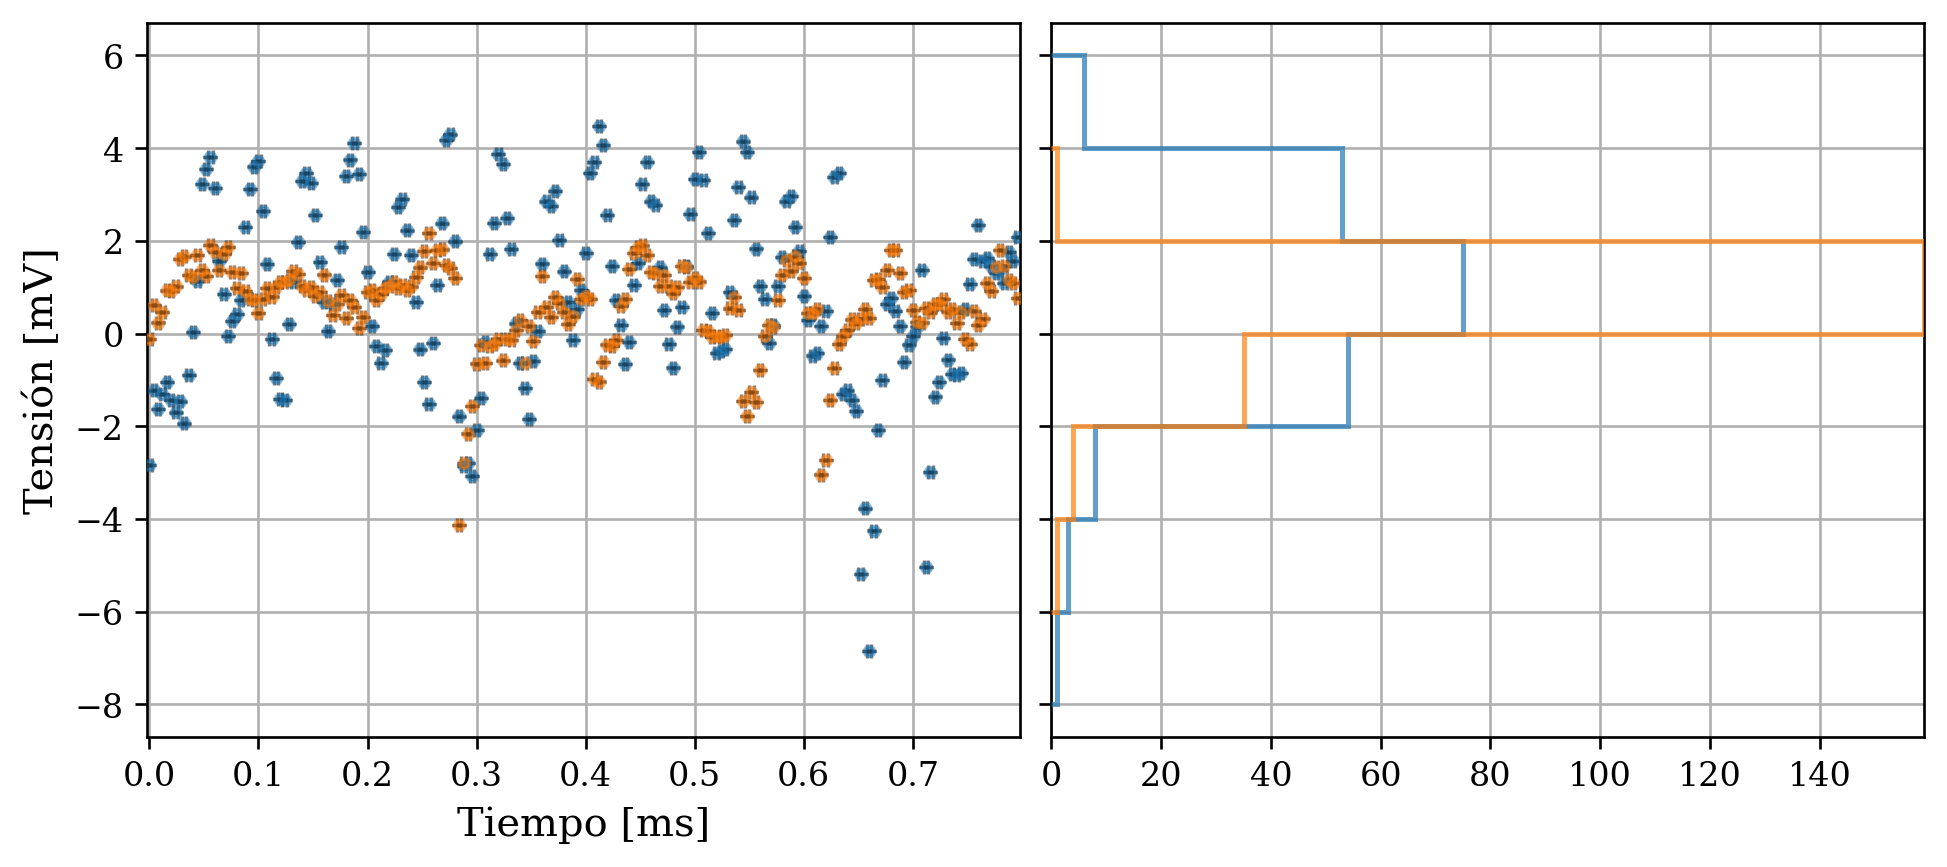

In [2]:
# Leer una tanda guardada:
config = "c"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                           + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V

# Ploteando de a cachos
fig, axs = ut.plot_measurements(tiempo, channel, min_val, max_val, med_index=0, n_datos=200)
ut.plot_measurements(tiempo, channel, min_val, max_val, med_index=6, n_datos=200, fig=fig)
plt.show()

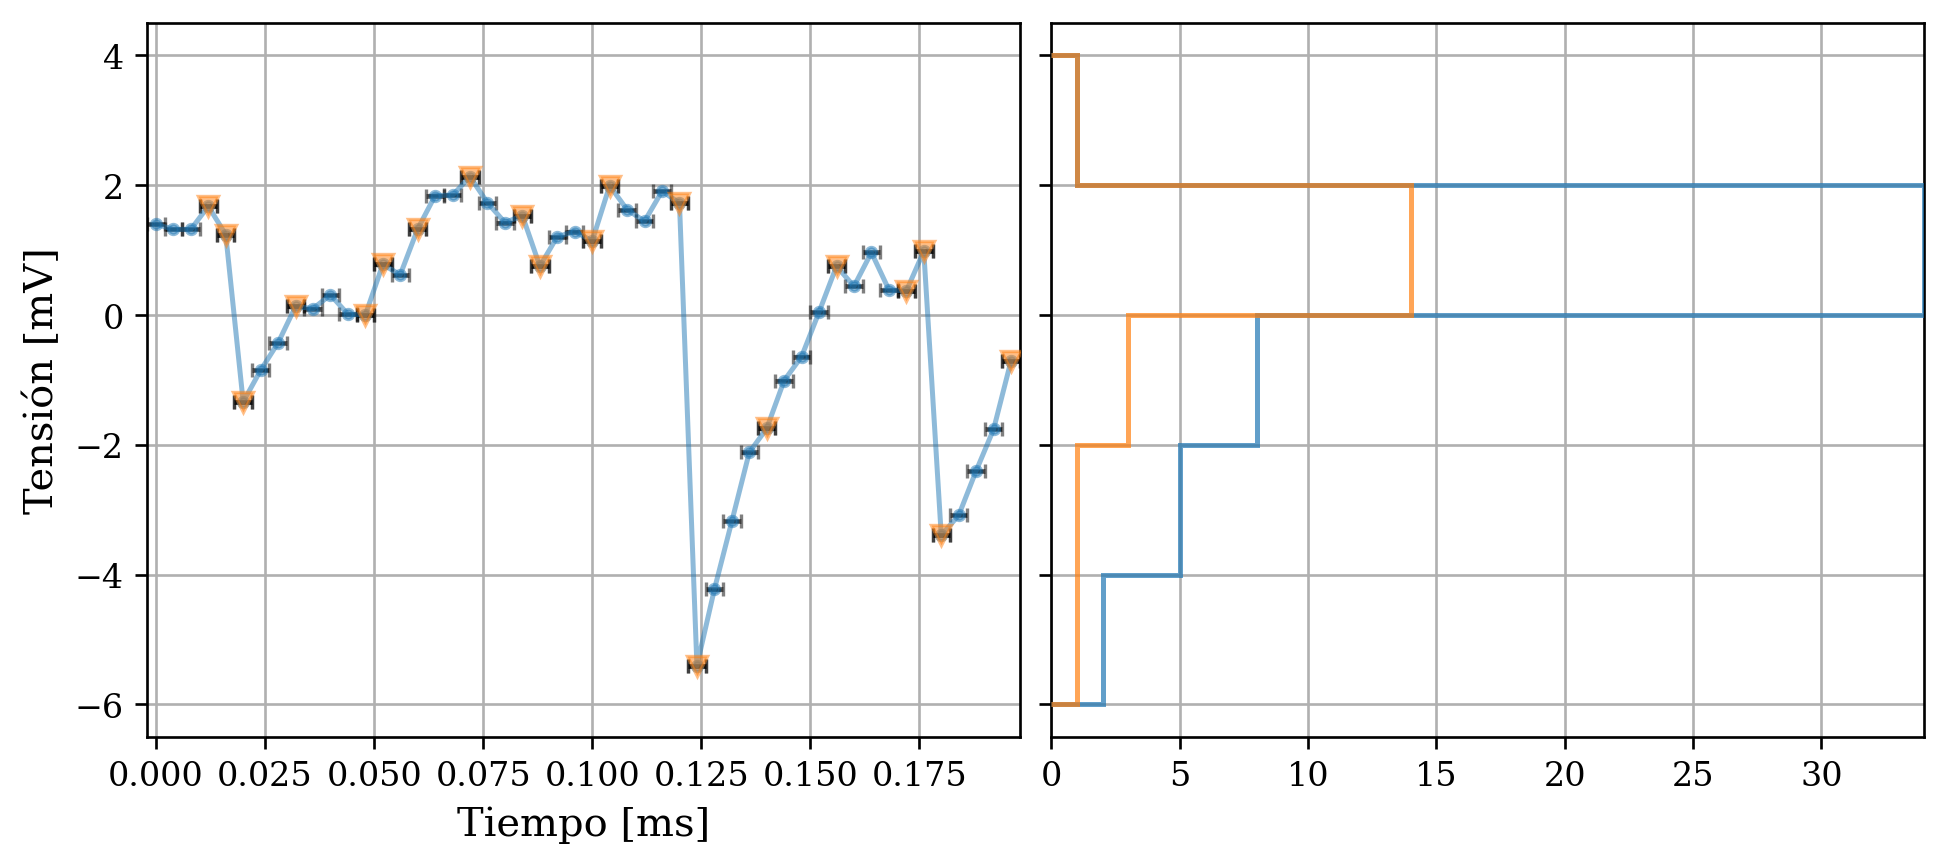

In [3]:
dt = 20  # μs
freq = 250e3  # Hz
w_size = int(dt*freq*1e-6)  # Window size in data points
n_datos = 50
med_index = 5
plot_args = tiempo, channel, min_val, max_val, med_index, n_datos
fig, axs = ut.plot_measurements(*plot_args)
ut.plot_custom_peaks(*plot_args, fig, window_size=w_size)
plt.show()

loaded c
ploted hist
loaded d
ploted hist


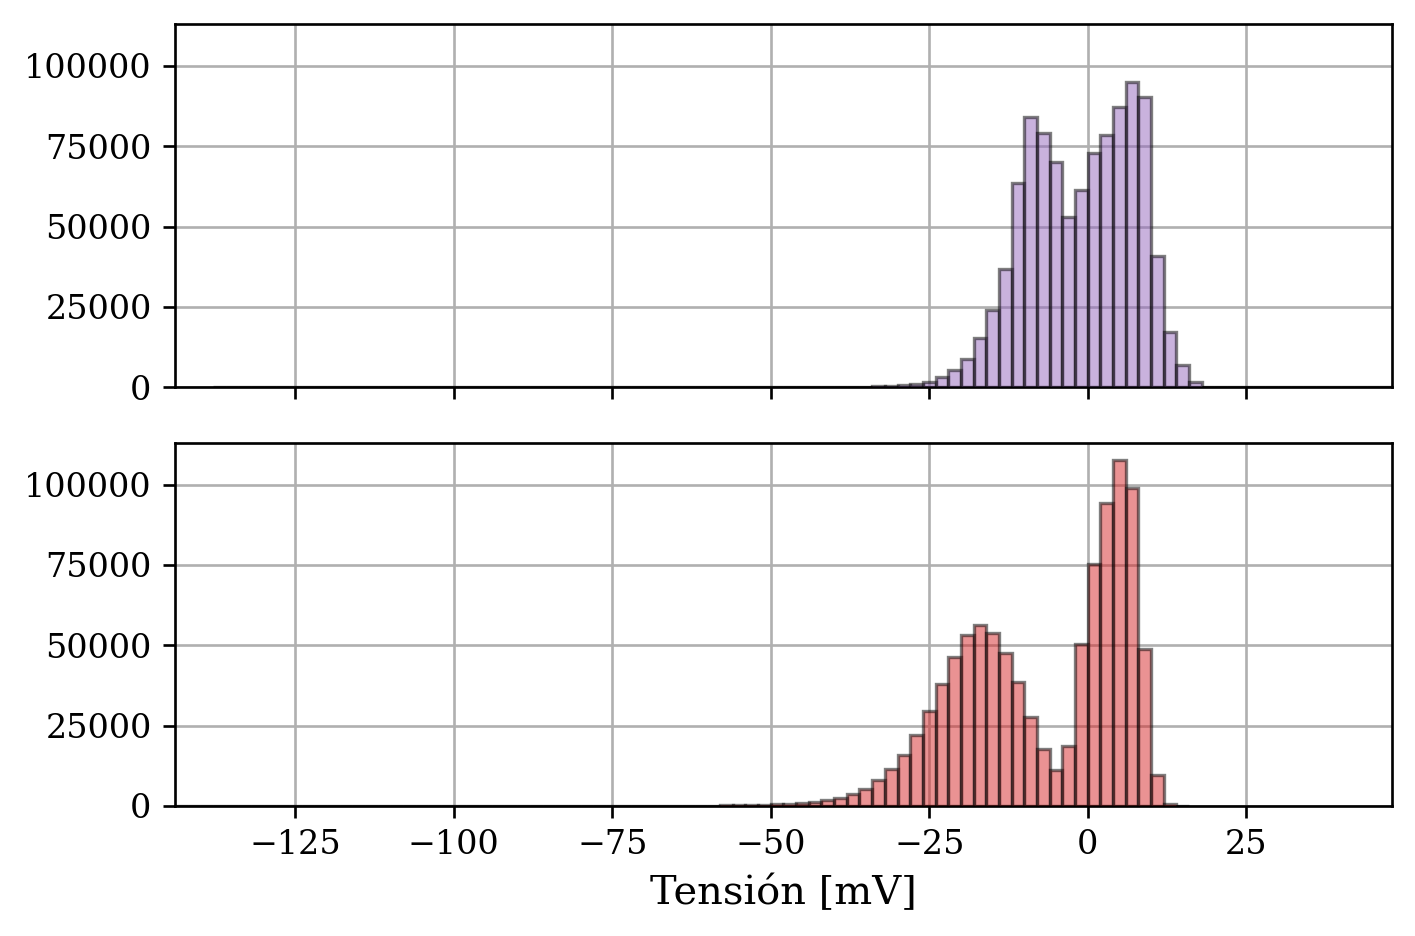

In [4]:
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
angulo = 230  # °
tension = 1050  # V
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True)
fig.subplots_adjust(hspace=0)
color_id = 4
height_dict = dict()
tension_dict = dict()
for config, ax in zip(["c", "d"], axs):
   
    tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
    print(f"loaded {config}")
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # V
    bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # V
    dt = 100  # μs
    t, v = ut.get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
    # v_maximos = v[v.size//2]
    obs, *_ = ax.hist(x=v*1e3, bins=bins,
                      color=f"C{color_id}", zorder=10, edgecolor="k",
                      alpha=0.5, label=config + " Sample")
    height_dict[config] = obs
    tension_dict[config] = bins[:-1] - 1
    print("ploted hist")
    color_id -= 1

    # ax.set_yscale("log")
ax.set_xlabel("Tensión [mV]")


plt.show()

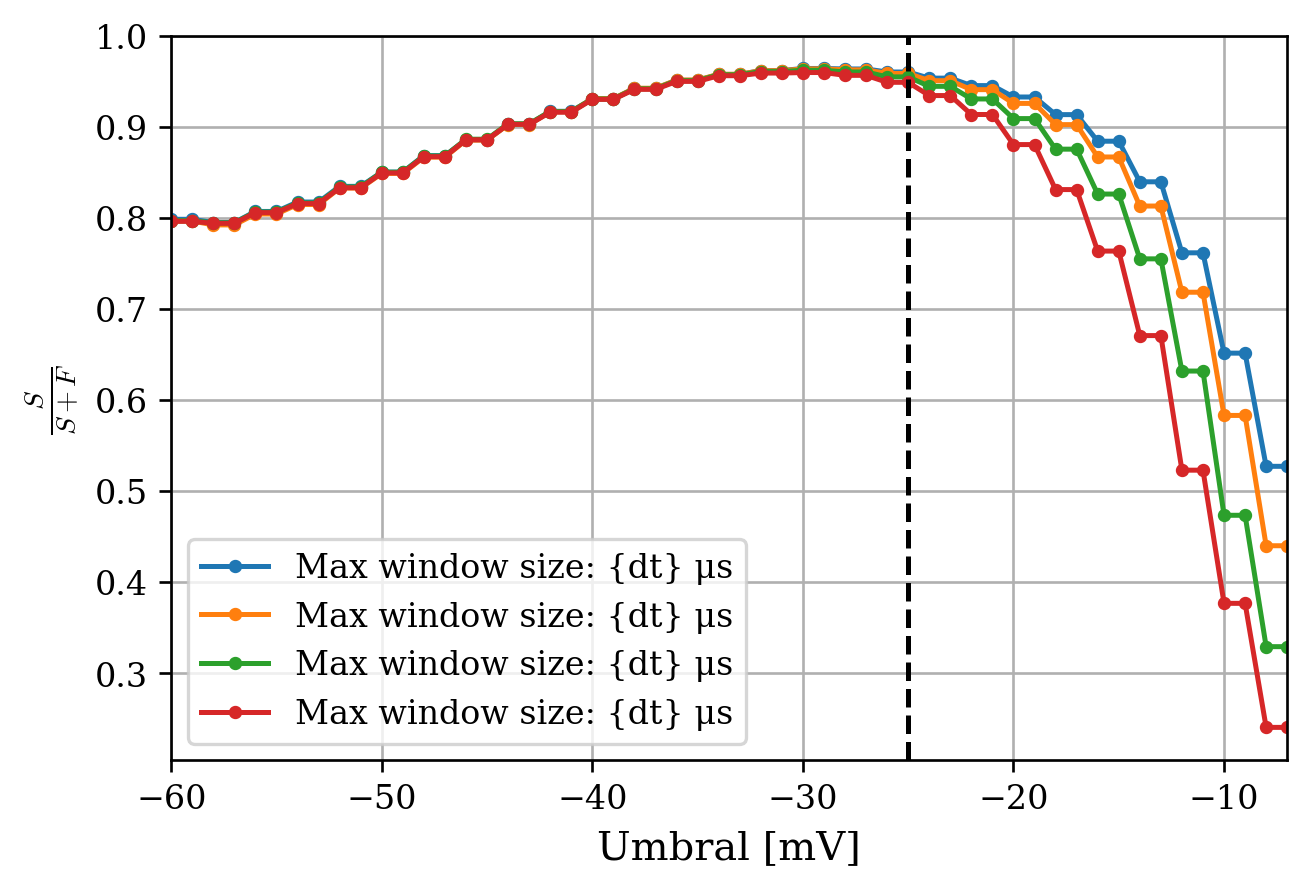

In [7]:
config_fondo = "c"
config_signal = "d"
for dt in [20, 40, 100, 200]:  # μs
    height_dict = dict()
    tension_dict = dict()
    for config, ax in zip(["c", "d"], axs):
        tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                    + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
        bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # V
        bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # V
        t, v = ut.get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
        # v_maximos = v[v.size//2]
        obs, *_ = np.histogram(v*1e3, bins=bins,)
        height_dict[config] = obs
        tension_dict[config] = bins[:-1] - 1


    umbrales = np.arange(-60, -6, 1, dtype=float)  # mV
    frac = np.zeros_like(umbrales)
    for i, umbral in enumerate(umbrales):  # V
        signal_and_back = sum(height_dict[config_signal][tension_dict[config_signal] <  umbral])
        background = sum(height_dict[config_fondo][tension_dict[config_fondo] <  umbral])
        # print(signal_and_back, background, umbral)
        frac[i] = (signal_and_back-background)/signal_and_back

    plt.plot(umbrales, frac, '.-', label=f"Max window size: {dt} μs")
plt.axvline(-25, ls='--', c="k")
plt.legend()
plt.xlabel("Umbral [mV]")
plt.ylabel(r"$\frac{S}{S+F}$")
plt.show()

# Poisson

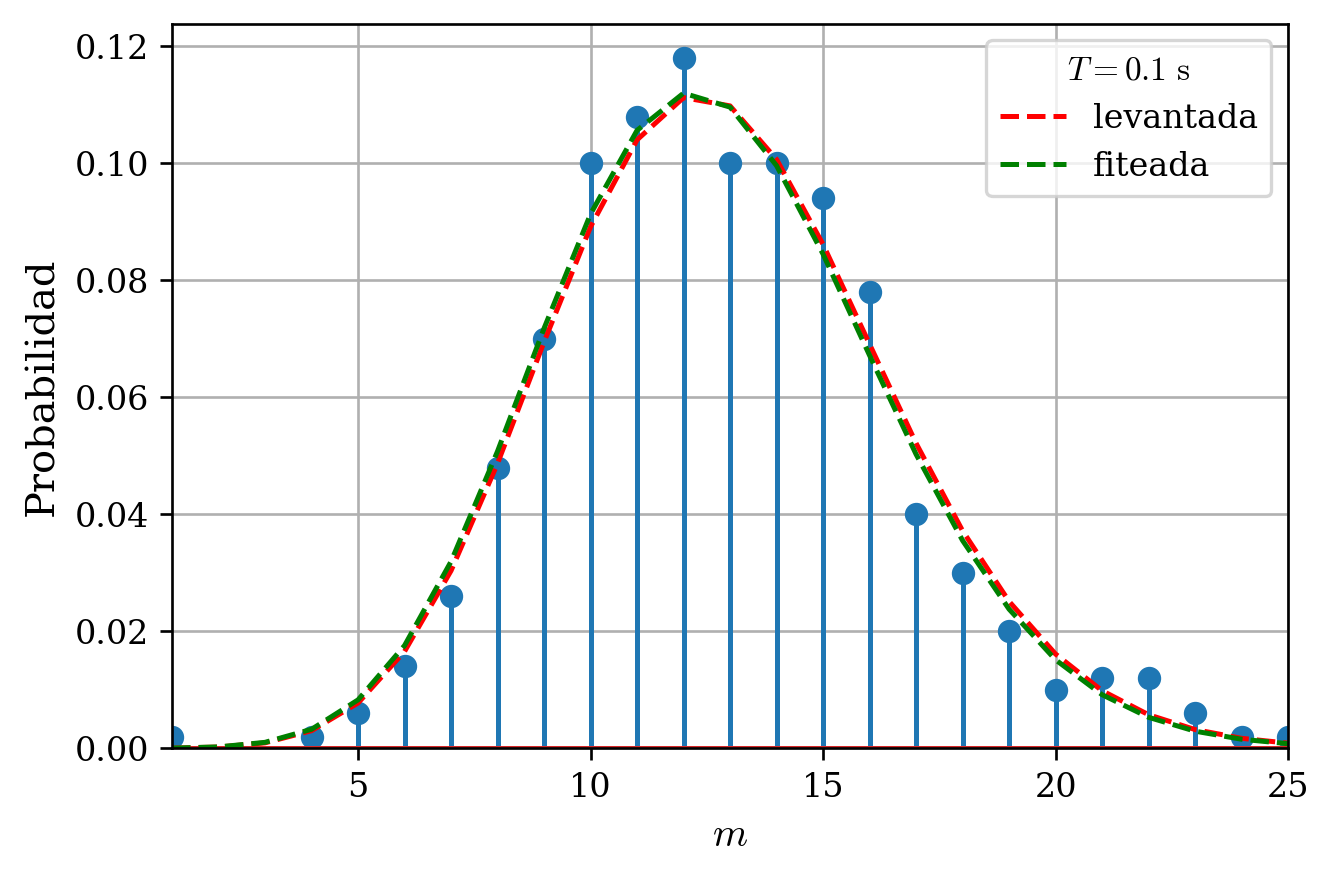

In [8]:
umbral = -40e-3  # V
dt = 100  # μs
T = 100e-3  # s
freq = 250e3  # Hz
peak_window = int(dt*freq*1e-6)
tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                            + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
t, v = ut.get_peaks(tiempo, volt_vals, peak_window)  # s, V
t, v = t[:t.size//2], v[:v.size//2]  # Keep just the max extremes


counts = ut.count_in_period(t, v, T, freq, umbral, peak_window)
unique_vals, count_vals = np.unique(counts, return_counts=True, )

mean_count = counts.mean()
curve_vals = np.arange(unique_vals.min(), unique_vals.max()+1, 1)

dist_raw = poisson(mean_count).pmf(curve_vals)
dist_med = count_vals/sum(count_vals)
popt, pcov = curve_fit(poisson.pmf, unique_vals, dist_med, p0=mean_count)
dist_fit = poisson(popt[0]).pmf(curve_vals)
# plt.hist(counts, bins=20,
#          color=f"C{color_id}", zorder=10, edgecolor="k",
#          alpha=0.5, label=config + " Sample")
plt.stem(unique_vals, dist_med)
plt.plot(curve_vals, dist_raw, '--r', label="levantada")
plt.plot(curve_vals, dist_fit, '--g', label="fiteada")

plt.legend(title=f"$T = {T}\ "+"\mathrm{s}$")
plt.ylim(bottom=0)
plt.xlabel("$m$")
plt.ylabel("Probabilidad")
plt.show()

## Bose-Einstein

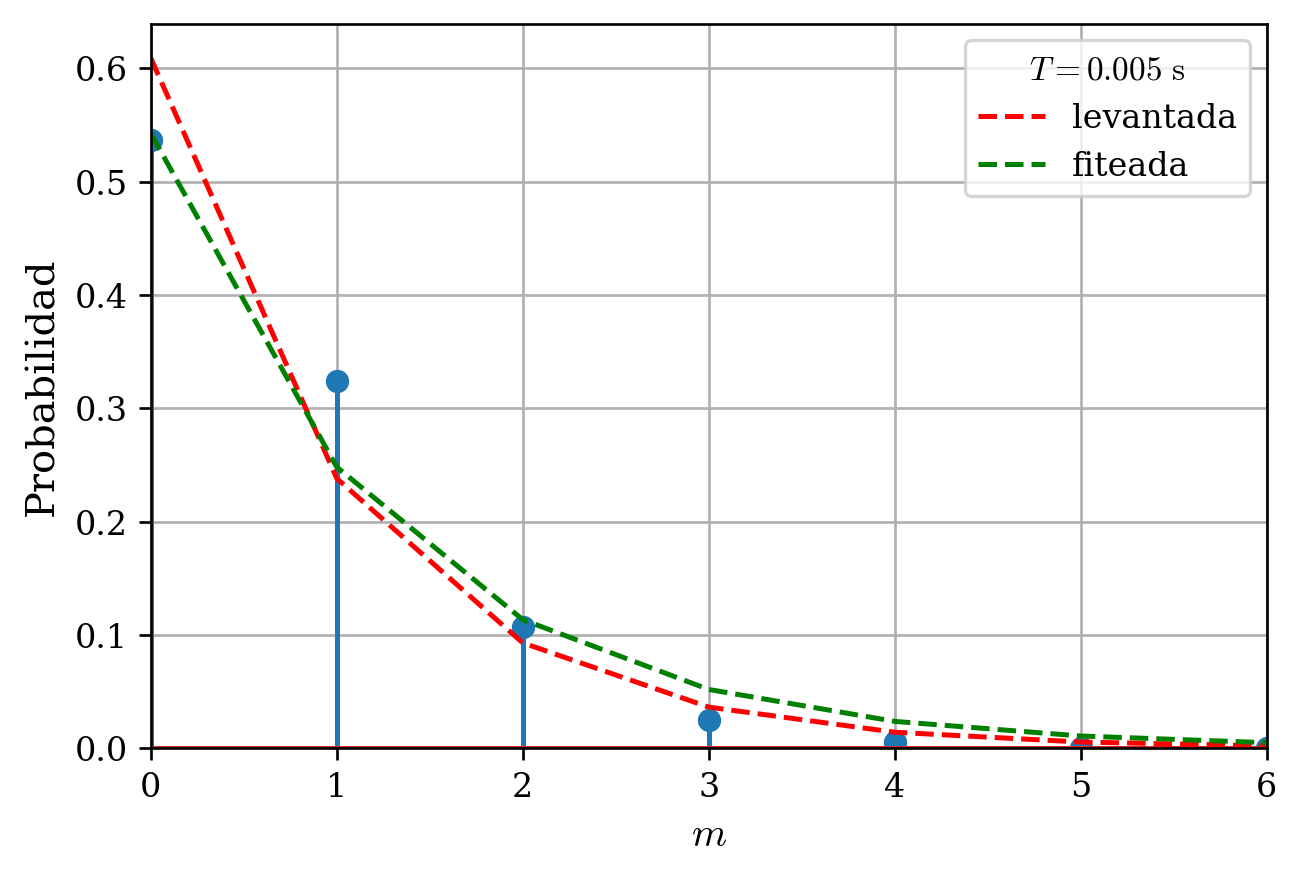

In [9]:
def bose_einstein_pmf(m, mu):
    return (mu**m)/(1 + mu)**(1+m)

umbral = -40e-3  # V
dt = 100  # μs
T = 5e-3  # s
freq = 250e3  # Hz
peak_window = int(dt*freq*1e-6)
tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                            + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
t, v = ut.get_peaks(tiempo, volt_vals, peak_window)  # s, V
t, v = t[:t.size//2], v[:v.size//2]  # Keep just the max extremes

counts = ut.count_in_period(t, v, T, freq, umbral, peak_window)
unique_vals, count_vals = np.unique(counts, return_counts=True, )

mean_count = counts.mean()
curve_vals = np.arange(unique_vals.min(), unique_vals.max()+1, 1)

dist_raw = bose_einstein_pmf(curve_vals, mean_count)
dist_med = count_vals/sum(count_vals)
popt, pcov = curve_fit(bose_einstein_pmf, unique_vals, dist_med, p0=mean_count)
dist_fit = bose_einstein_pmf(curve_vals, popt[0])
# plt.hist(counts, bins=20,
#          color=f"C{color_id}", zorder=10, edgecolor="k",
#          alpha=0.5, label=config + " Sample")
plt.stem(unique_vals, dist_med)
plt.plot(curve_vals, dist_raw, '--r', label="levantada")
plt.plot(curve_vals, dist_fit, '--g', label="fiteada")

plt.legend(title=f"$T = {T}\ "+"\mathrm{s}$")
plt.ylim(bottom=0)
plt.xlabel("$m$")
plt.ylabel("Probabilidad")
plt.show()